### Using Zs in CAUSICA

In [1]:
import pytorch_lightning as pl
seed = 1
pl.seed_everything(seed)  # set the random seed

Seed set to 1


1

In [2]:
import os
from dataclasses import dataclass

import networkx as nx
import torch
from tensordict import TensorDict
from torch.utils.data import DataLoader

from causica.datasets.causica_dataset_format import CAUSICA_DATASETS_PATH, DataEnum, load_data, VariablesMetadata
from causica.datasets.tensordict_utils import tensordict_shapes
from causica.distributions import (
    AdjacencyDistribution,
    ContinuousNoiseDist,
    DistributionModule,
    ENCOAdjacencyDistributionModule,
    GibbsDAGPrior,
    JointNoiseModule,
    create_noise_modules,
)
from causica.functional_relationships import DECIEmbedFunctionalRelationships
from causica.graph.dag_constraint import calculate_dagness
from causica.sem.sem_distribution import SEMDistributionModule
from causica.training.auglag import AugLagLossCalculator, AugLagLR, AugLagLRConfig

Define various parameters of the training process.

In [6]:
@dataclass(frozen=True)
class TrainingConfig:
    noise_dist: ContinuousNoiseDist = ContinuousNoiseDist.SPLINE
    batch_size: int = 128
    max_epoch: int = int(os.environ.get("TEST_RUN", 2000))  # used by testing to run the notebook as a script
    gumbel_temp: float = 0.25
    averaging_period: int = 10
    prior_sparsity_lambda: float = 5.0
    init_rho: float = 1.0
    init_alpha: float = 0.0


training_config = TrainingConfig()
auglag_config = AugLagLRConfig()
device = "cuda" if torch.cuda.is_available() else "cpu"

We now download the dataset from Azure Blob storage.

The Causica repo makes heavy use of [TensorDict](https://pytorch.org/rl/tensordict/reference/generated/tensordict.TensorDict.html). A dataset is assumed to be a TensorDict, with each key containing the data associated with a given node.

The `variables_metadata` object stored with the CSuite data also describes the type of each node, which we will need when we create the Noise Distributions for each node.

In [9]:
root_path = '.'
variables_metadata = load_data(root_path, DataEnum.VARIABLES_JSON)

In [11]:
dataset_train: TensorDict = load_data(root_path, DataEnum.TRAIN, variables_metadata)
dataset_train = dataset_train.apply(lambda t: t.to(dtype=torch.float32, device=device))

dataloader_train = DataLoader(
    dataset=dataset_train,
    collate_fn=lambda x: x,
    batch_size=training_config.batch_size,
    shuffle=True,
)

Create a prior distribution over DAGs.

In [12]:
num_nodes = len(dataset_train.keys())

prior = GibbsDAGPrior(num_nodes=num_nodes, sparsity_lambda=training_config.prior_sparsity_lambda)
num_nodes

6

In [13]:
print(prior.batch_shape, prior.event_shape)
prior._num_nodes, prior._expert_graph_container, prior._sparsity_lambda

torch.Size([]) torch.Size([6, 6])


(6, None, 5.0)

Create the Variational Posterior Distribution over Adjacency Matrices, which we will optimize.

In [14]:
adjacency_dist: DistributionModule[AdjacencyDistribution] = ENCOAdjacencyDistributionModule(num_nodes)

Create the Graph Neural network that will estimate the functional relationships. More info can be found [here](https://openreview.net/forum?id=S2pNPZM-w-f).

In [15]:
functional_relationships = DECIEmbedFunctionalRelationships(
    shapes=tensordict_shapes(dataset_train),
    embedding_size=32,
    out_dim_g=32,
    num_layers_g=2,
    num_layers_zeta=2,
)

In [16]:
tensordict_shapes(dataset_train)

{'y0': torch.Size([10]),
 'y1': torch.Size([10]),
 'y2': torch.Size([10]),
 'z0': torch.Size([1]),
 'z1': torch.Size([1]),
 'z2': torch.Size([1])}

In [ ]:
import seaborn as sns
sns.heatmap(functional_relationships.nn.group_mask)

In [19]:
num_nodes, concatenated_shape = functional_relationships.nn.group_mask.shape
num_nodes, concatenated_shape

(6, 33)

In [20]:
functional_relationships

DECIEmbedFunctionalRelationships(
  (nn): DECIEmbedNN(
    (l): Sequential(
      (0): Sequential(
        (0): Linear(in_features=65, out_features=132, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      )
      (1): _ResBlock(
        (block): Sequential(
          (0): LayerNorm((132,), eps=1e-05, elementwise_affine=True)
          (1): Linear(in_features=132, out_features=132, bias=True)
          (2): LeakyReLU(negative_slope=0.01)
        )
      )
      (2): LayerNorm((132,), eps=1e-05, elementwise_affine=True)
      (3): Linear(in_features=132, out_features=32, bias=True)
    )
    (zeta): Sequential(
      (0): Sequential(
        (0): Linear(in_features=64, out_features=132, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      )
      (1): _ResBlock(
        (block): Sequential(
          (0): LayerNorm((132,), eps=1e-05, elementwise_affine=True)
          (1): Linear(in_features=132, out_features=132, bias=True)
          (2): LeakyReLU(negative_slope=0.01)


Create the Noise Distributions for each node using the definitions in `variables_metadata`.

In [24]:
variable_shapes = tensordict_shapes(dataset_train)

types_dict = {var.group_name: var.type for var in variables_metadata.variables}

noise_submodules = create_noise_modules(variable_shapes, types_dict, training_config.noise_dist)
noise_module = JointNoiseModule(noise_submodules)

In [25]:
noise_submodules['z0']().base_dist

SplineNoise()

In [26]:
noise_submodules['y0']()

CategoricalNoise()

Create the SEM Module which combines the variational adjacency distribution, the functional relationships and the noise distributions for each node.

In [27]:
sem_module: SEMDistributionModule = SEMDistributionModule(adjacency_dist, functional_relationships, noise_module)

sem_module.to(device);

In [28]:
sem_module()

SEMDistribution()

In [29]:
sem_module

SEMDistributionModule(
  (adjacency_module): ENCOAdjacencyDistributionModule()
  (functional_relationships): DECIEmbedFunctionalRelationships(
    (nn): DECIEmbedNN(
      (l): Sequential(
        (0): Sequential(
          (0): Linear(in_features=65, out_features=132, bias=True)
          (1): LeakyReLU(negative_slope=0.01)
        )
        (1): _ResBlock(
          (block): Sequential(
            (0): LayerNorm((132,), eps=1e-05, elementwise_affine=True)
            (1): Linear(in_features=132, out_features=132, bias=True)
            (2): LeakyReLU(negative_slope=0.01)
          )
        )
        (2): LayerNorm((132,), eps=1e-05, elementwise_affine=True)
        (3): Linear(in_features=132, out_features=32, bias=True)
      )
      (zeta): Sequential(
        (0): Sequential(
          (0): Linear(in_features=64, out_features=132, bias=True)
          (1): LeakyReLU(negative_slope=0.01)
        )
        (1): _ResBlock(
          (block): Sequential(
            (0): LayerNorm((

Create the optimizer, with separate learning rates for each module.

In [30]:
modules = {
    "functional_relationships": sem_module.functional_relationships,
    "vardist": sem_module.adjacency_module,
    "noise_dist": sem_module.noise_module,
}
parameter_list = [
    {"params": module.parameters(), "lr": auglag_config.lr_init_dict[name], "name": name}
    for name, module in modules.items()
]

optimizer = torch.optim.Adam(parameter_list)

Define the [Augmented Lagrangian Scheduler](https://en.wikipedia.org/wiki/Augmented_Lagrangian_method).

This allows DECI to optimize towards a DAG, by slowly increasing the alpha and rho parameters as the optimization takes place

In [31]:
scheduler = AugLagLR(config=auglag_config)
auglag_loss = AugLagLossCalculator(init_alpha=training_config.init_alpha, init_rho=training_config.init_rho)

The main training loop.

For each batch, we:
* Sample a graph from the SEM.
* Calculate the log probability of that batch, given the graph.
* Create the ELBO to be optimized.
* Calculate the DAG constraint
* Combine the DAG constraint with the ELBO to get the loss.

In [39]:
from tqdm.notebook import tqdm

In [40]:
assert len(dataset_train.batch_size) == 1, "Only 1D batch size is supported"
num_samples = len(dataset_train)
# for epoch in range(training_config.max_epoch):
for epoch in tqdm(range(500)):
    for i, batch in enumerate(dataloader_train):
        optimizer.zero_grad()
        sem_distribution = sem_module()
        sem, *_ = sem_distribution.relaxed_sample(
            torch.Size([]), temperature=training_config.gumbel_temp
        )  # soft sample

        batch_log_prob = sem.log_prob(batch).mean()
        sem_distribution_entropy = sem_distribution.entropy()
        prior_term = prior.log_prob(sem.graph)
        objective = (-sem_distribution_entropy - prior_term) / num_samples - batch_log_prob
        constraint = calculate_dagness(sem.graph)

        loss = auglag_loss(objective, constraint / num_samples)

        loss.backward()
        optimizer.step()
        # update the Auglag parameters
        scheduler.step(
            optimizer=optimizer,
            loss=auglag_loss,
            loss_value=loss,
            lagrangian_penalty=constraint,
        )
        # log metrics
        if epoch % 10 == 0 and i == 0:
            print(
                f"epoch:{epoch} loss:{loss.item():.5g} nll:{-batch_log_prob.detach().cpu().numpy():.5g} "
                f"dagness:{constraint.item():.5f} num_edges:{(sem.graph > 0.0).sum()} "
                f"alpha:{auglag_loss.alpha:.5g} rho:{auglag_loss.rho:.5g} "
                f"step:{scheduler.outer_opt_counter}|{scheduler.step_counter} "
                f"num_lr_updates:{scheduler.num_lr_updates}"
            )

  0%|          | 0/500 [00:00<?, ?it/s]

epoch:0 loss:53.035 nll:10.6 dagness:0.50417 num_edges:15 alpha:5.0417e+06 rho:1e+07 step:9|168 num_lr_updates:0
Updating alpha to: 25208728.0
Updating alpha to: 126043640.0
epoch:10 loss:10.628 nll:10.627 dagness:0.00000 num_edges:14 alpha:1.2604e+08 rho:1e+07 step:11|672 num_lr_updates:1
Updating alpha to: 630218176.0
Updating alpha to: 3151090944.0
Updating alpha to: 15755454464.0
epoch:20 loss:10.446 nll:10.445 dagness:0.00000 num_edges:14 alpha:1.5755e+10 rho:1e+07 step:14|1303 num_lr_updates:2
epoch:30 loss:10.399 nll:10.398 dagness:0.00000 num_edges:14 alpha:1.5755e+10 rho:1e+07 step:14|5983 num_lr_updates:3
epoch:40 loss:10.342 nll:10.341 dagness:0.00000 num_edges:14 alpha:1.5755e+10 rho:1e+07 step:14|10663 num_lr_updates:3
epoch:50 loss:10.623 nll:10.621 dagness:0.00000 num_edges:14 alpha:1.5755e+10 rho:1e+07 step:14|15343 num_lr_updates:3
epoch:60 loss:10.412 nll:10.411 dagness:0.00000 num_edges:14 alpha:1.5755e+10 rho:1e+07 step:14|20023 num_lr_updates:3
epoch:70 loss:10.549

KeyboardInterrupt: 

In [35]:
torch.save(sem_module.state_dict(), 'sem_module.pth')
sem_module.load_state_dict(torch.load('sem_module.pth'))

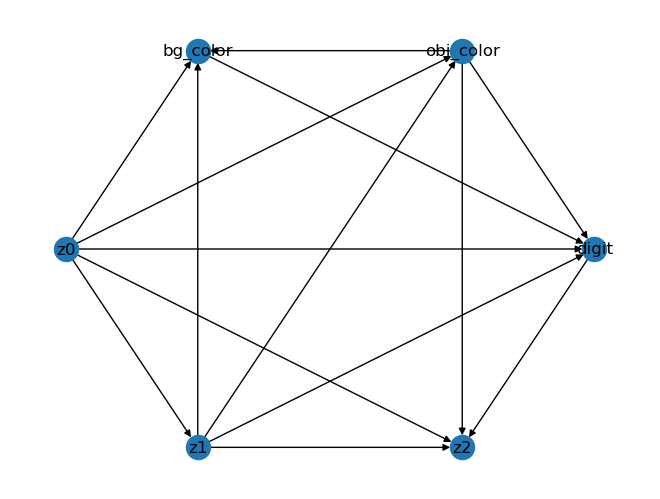

In [50]:
labeldict = {i: l for i, l in enumerate(['digit', 'obj_color', 'bg_color', 'z0', 'z1', 'z2'])}
vardist = adjacency_dist()
graph = nx.from_numpy_array(vardist.mode.cpu().numpy(), create_using=nx.DiGraph)
nx.draw_circular(graph, labels=labeldict, with_labels=True, arrows=True)

In [53]:
vardist.mode.cpu().numpy()

array([[0., 0., 0., 0., 0., 1.],
       [1., 0., 1., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 1., 1.],
       [1., 1., 1., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0.]], dtype=float32)

In [54]:
nx.is_directed_acyclic_graph(graph)

True

In [55]:
torch.save(sem_module.state_dict(), 'sem_module.pth')

In [14]:
### Using Zs in CAUSICA
vardist_mode = np.array([[0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 0.],
       [0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.]], dtype='float32')

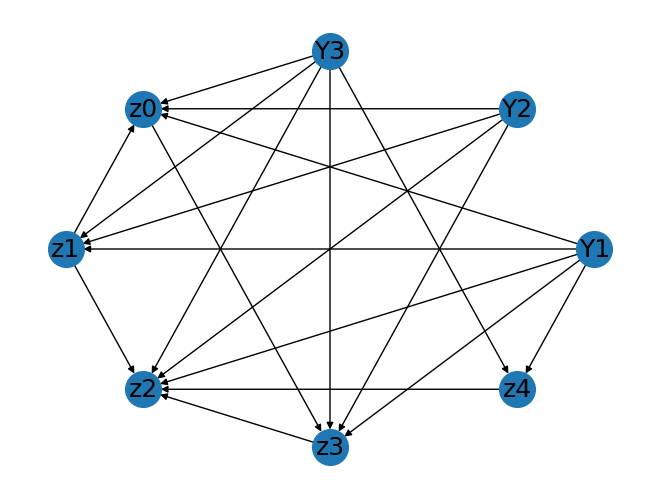

In [17]:
import networkx as nx
Z_DIM = 5
labeldict = {i: l for i, l in enumerate(['Y1', 'Y2', 'Y3']+['z'+str(j) for j in range(Z_DIM)])}
graph = nx.from_numpy_array(vardist_mode, create_using=nx.DiGraph)
nx.draw_circular(graph, labels=labeldict, node_size=660, font_size=18, with_labels=True, arrows=True)